In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import nltk
from collections import OrderedDict
import pickle
%matplotlib inline

In [10]:
risk_qa = pd.read_excel("risk_data.xlsx")

In [11]:
risk_qa.head()

,客戶編號,風險等級,風險等級分類,適性評量填寫日期,適性版號,題目序號,KYC_QUESTION,ANS_ORDER,ANS_ITEM,答題得分,客戶職業與任職部門,AGENT代碼
0,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A0,是否為其他國家稅務居住者?,1,1.否,0,NaN,9999999999
1,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A01,職業／行業別,8,8.退休人士,0,NaN,9999999999
2,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A02,職務,1,1.基層職員,0,NaN,9999999999
3,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A03,任職單位,1,1.任職公司／機構,0,寶豐,9999999999
4,261909,5,積極型,2018-10-30 22:54:34.523,201809A,A03,任職單位,2,2.任職部門,0,營建,9999999999


In [12]:
uni_id = np.unique(risk_qa["客戶編號"])

In [13]:
attr_dict = defaultdict(lambda: defaultdict(list))
max_ans_dict = defaultdict(int) # record max answer num for each question (for one-hot array)

for index, row in risk_qa.iterrows():
    attr_dict[row["客戶編號"]][row["題目序號"]].append(row["ANS_ORDER"])
    if max_ans_dict[row["題目序號"]]<row["ANS_ORDER"]:
        max_ans_dict[row["題目序號"]] = row["ANS_ORDER"]


In [14]:
# filter out duplicate
for k1 in attr_dict.keys():
    for k2 in attr_dict[k1].keys():
        attr_dict[k1][k2] = list(set(attr_dict[k1][k2]))

In [15]:
# 問卷答案的字典
attr_dict

defaultdict(<function __main__.<lambda>>,
            {261909: defaultdict(list,
                         {'A0': [1],
                          'A01': [8],
                          'A02': [1],
                          'A03': [1, 2],
                          'A04': [4],
                          'A05': [3],
                          'A06': [1],
                          'A07': [1],
                          'A08': [1, 3, 5],
                          'A09': [2, 3],
                          'A10': [2],
                          'A11': [1],
                          'A12': [1],
                          'A13': [1],
                          'A14': [4],
                          'B01': [3],
                          'B02': [1, 2, 3, 4, 5],
                          'B03': [3, 4, 5],
                          'B04': [5],
                          'B05': [4],
                          'B06': [4],
                          'B07': [4]}),
             269963: defaultdict(list,
             

#### 每個答案做成一個字 ， 每個 user 當一篇文章，計算答案的共現性


In [16]:
doc_word_list = []
for uid in attr_dict.keys():
    single_word_list = []
    for aid in attr_dict[uid].keys():
        single_word_list += [aid + "_" + str(ans) for ans in attr_dict[uid][aid]]
    doc_word_list.append(single_word_list)

In [17]:
names = list(set([w for l in doc_word_list for w in l]))
occurrences = OrderedDict((name, OrderedDict((name, 0) for name in names)) for name in names)
 
# Find the co-occurrences:
for l in doc_word_list:
    for i in range(len(l)):
        for item in l[:i] + l[i + 1:]:
            occurrences[l[i]][item] += 1
            
co_occur = pd.DataFrame.from_dict(occurrences)

In [18]:
# co_occur.to_csv('./answer_cooccurance_matrix.csv')

### query and ranking 

In [19]:
query = "A01_2"
print("Ranking")
co_occur[query].sort_values(ascending=False)

Ranking


A0_1      119
A07_1     119
A03_1     119
A03_2     119
A14_4     118
A06_1     115
A09_1     112
B02_1     109
B03_4     108
A13_1     107
B02_4     102
A12_1      93
B03_5      92
A08_5      88
B02_3      86
A08_1      83
B02_5      83
B05_4      72
A05_2      69
A10_3      67
B01_5      64
A08_3      63
A09_3      61
B03_3      61
B04_5      60
B02_2      59
A04_5      57
A11_2      53
B07_5      50
B06_5      46
         ... 
A01_12      0
A01_13      0
A01_14      0
A01_2       0
A01_20      0
A01_18      0
A01_19      0
A01_23      0
A01_22      0
A01_5       0
A01_21      0
A01_4       0
B05_1       0
A01_6       0
A11_5       0
A08_7       0
A09_9       0
A0_3        0
A06_5       0
A06_4       0
A06_2       0
A14_2       0
A01_7       0
A14_3       0
B01_1       0
A04_1       0
B01_2       0
A01_9       0
A01_8       0
A01_1       0
Name: A01_2, Length: 117, dtype: int64

### t-testing

In [20]:
doc_word_list

[['A0_1',
  'A01_8',
  'A02_1',
  'A03_1',
  'A03_2',
  'A04_4',
  'A05_3',
  'A06_1',
  'A07_1',
  'A08_1',
  'A08_3',
  'A08_5',
  'A09_2',
  'A09_3',
  'A10_2',
  'A11_1',
  'A12_1',
  'A13_1',
  'A14_4',
  'B01_3',
  'B02_1',
  'B02_2',
  'B02_3',
  'B02_4',
  'B02_5',
  'B03_3',
  'B03_4',
  'B03_5',
  'B04_5',
  'B05_4',
  'B06_4',
  'B07_4'],
 ['A0_1',
  'A01_6',
  'A02_1',
  'A03_1',
  'A03_2',
  'A04_4',
  'A05_2',
  'A06_1',
  'A07_1',
  'A08_3',
  'A08_4',
  'A08_5',
  'A09_1',
  'A09_3',
  'A10_3',
  'A11_2',
  'A12_1',
  'A13_1',
  'A14_4',
  'B01_5',
  'B02_4',
  'B02_5',
  'B03_4',
  'B03_5',
  'B04_3',
  'B05_3',
  'B06_2',
  'B07_1'],
 ['A0_1',
  'A01_3',
  'A02_1',
  'A03_1',
  'A03_2',
  'A04_4',
  'A05_2',
  'A06_1',
  'A07_1',
  'A08_1',
  'A08_4',
  'A08_5',
  'A09_1',
  'A10_2',
  'A11_1',
  'A12_1',
  'A13_1',
  'A14_4',
  'B01_5',
  'B02_1',
  'B02_2',
  'B02_3',
  'B02_4',
  'B02_5',
  'B03_1',
  'B03_2',
  'B03_3',
  'B03_4',
  'B03_5',
  'B04_3',
  'B05_3',


In [23]:
total_words = [word for doc in doc_word_list for word in doc]
total_words_count = len(total_words)
words_p_dict = {}
uniq = np.unique(total_words, return_counts=True)
for word, count in zip(uniq[0], uniq[1]):
    words_p_dict[word] = count/total_words_count
    
co_occur_prob = co_occur/total_words_count

In [24]:
t_test_dict = OrderedDict((name, OrderedDict((name, 0) for name in names)) for name in names)
significant_dict = defaultdict(list)
for name1 in names:
    for name2 in names:
        u = words_p_dict[name1]*words_p_dict[name2]
        if name1 == name2:
            x_bar = 1
        else:
            x_bar = co_occur_prob[name1][name2]
        if x_bar == 0.:
            value = 0
        else: 
            value = (x_bar-u)/(x_bar/total_words_count)**0.5
        t_test_dict[name1][name2] = value
        if value> 2.576:
            significant_dict[name1].append(name2)

t_test = pd.DataFrame.from_dict(t_test_dict)

In [25]:
significant_dict

defaultdict(list,
            {'A01_1': ['B03_4',
              'B06_4',
              'A10_2',
              'A02_4',
              'B02_4',
              'B07_3',
              'A09_4',
              'B01_3',
              'B01_5',
              'A03_1',
              'A11_2',
              'B05_4',
              'A05_3',
              'A11_3',
              'A08_3',
              'B02_1',
              'A10_4',
              'A12_2',
              'A01_1',
              'A02_1',
              'B07_1',
              'B06_3',
              'A09_3',
              'B01_4',
              'B03_1',
              'B07_5',
              'A14_4',
              'A08_6',
              'A13_2',
              'B03_5',
              'B07_4',
              'A02_3',
              'B06_5',
              'A09_1',
              'A09_7',
              'B03_2',
              'A04_4',
              'B02_2',
              'B02_5',
              'A10_3',
              'A02_2',
              'A06_1',
       

In [26]:
t_test["A01_2"].sort_values(ascending=False)

A01_2     232.775594
A0_1       10.529821
A07_1      10.529821
A03_1      10.529419
A03_2      10.529419
A14_4      10.497653
A06_1      10.366234
A09_1      10.290610
B02_1      10.098478
B03_4      10.067917
A13_1       9.984210
B02_4       9.758754
A12_1       9.309338
B03_5       9.290571
A08_5       9.085146
B02_3       8.997960
B02_5       8.818749
A08_1       8.812722
B05_4       8.200836
A05_2       8.024521
A10_3       7.933413
B01_5       7.799873
A08_3       7.676886
B03_3       7.565331
A09_3       7.511061
B04_5       7.467545
B02_2       7.427822
A04_5       7.420970
A11_2       7.020373
B07_5       6.835643
             ...    
A01_23      0.000000
A01_22      0.000000
A01_21      0.000000
A01_20      0.000000
A01_19      0.000000
A01_5       0.000000
A01_18      0.000000
A01_17      0.000000
A01_14      0.000000
A01_13      0.000000
A01_12      0.000000
A01_10      0.000000
A01_4       0.000000
A01_6       0.000000
A14_2       0.000000
A01_7       0.000000
A01_8       0

In [27]:
# t_test.to_csv('./t_test.csv')

In [7]:
t_test = pd.read_csv('./t_test.csv', index_col=0)

t_test["A01_2"].sort_values(ascending=False)

In [41]:
# create feature matrix

In [45]:
question_list = list(max_ans_dict.keys())
print(question_list)

['A0', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07']


In [52]:
max_ans_dict

defaultdict(int,
            {'A0': 3,
             'A01': 24,
             'A02': 7,
             'A03': 2,
             'A04': 5,
             'A05': 3,
             'A06': 6,
             'A07': 1,
             'A08': 7,
             'A09': 9,
             'A10': 5,
             'A11': 5,
             'A12': 3,
             'A13': 2,
             'A14': 4,
             'B01': 5,
             'B02': 5,
             'B03': 5,
             'B04': 5,
             'B05': 5,
             'B06': 5,
             'B07': 5})

In [55]:
attr_dict[261909]

defaultdict(list,
            {'A0': [1],
             'A01': [8],
             'A02': [1],
             'A03': [1, 2],
             'A04': [4],
             'A05': [3],
             'A06': [1],
             'A07': [1],
             'A08': [1, 3, 5],
             'A09': [2, 3],
             'A10': [2],
             'A11': [1],
             'A12': [1],
             'A13': [1],
             'A14': [4],
             'B01': [3],
             'B02': [1, 2, 3, 4, 5],
             'B03': [3, 4, 5],
             'B04': [5],
             'B05': [4],
             'B06': [4],
             'B07': [4]})

In [95]:
pickle.dump(max_ans_dict, open("./max_ans_dict.pkl","wb"))
max_ans_dict

defaultdict(int,
            {'A0': 3,
             'A01': 24,
             'A02': 7,
             'A03': 2,
             'A04': 5,
             'A05': 3,
             'A06': 6,
             'A07': 1,
             'A08': 7,
             'A09': 9,
             'A10': 5,
             'A11': 5,
             'A12': 3,
             'A13': 2,
             'A14': 4,
             'B01': 5,
             'B02': 5,
             'B03': 5,
             'B04': 5,
             'B05': 5,
             'B06': 5,
             'B07': 5})

## create feature matrix (one-hot encoding)

In [46]:
feature_matrix = []
id_list = []
uid_feature_dict = defaultdict()
for user in attr_dict.keys():
    single_user_feature = []
    for q in question_list:
        ans = np.array(attr_dict[user][q])-1
        one_hot = np.zeros(max_ans_dict[q])
        if len(ans)!=0:
            one_hot[ans] = 1
        single_user_feature.append(one_hot)
    merge_feature = np.hstack(single_user_feature)
    feature_matrix.append(merge_feature)
    id_list.append(user)
    uid_feature_dict[user] = merge_feature
feature_matrix = np.vstack(feature_matrix)

In [88]:
# question answer indexing
user_id = 159728
q_id = "B02"
q_index = list(max_ans_dict.keys()).index(q_id)
start_index = sum(list(max_ans_dict.values())[:q_index])
end_index = start_index+max_ans_dict[q_id]
print(uid_feature_dict[user_id][start_index:end_index])

[1. 1. 1. 1. 1.]


In [92]:
pickle.dump(uid_feature_dict, open("./uid_feature_dict.pkl","wb"))

In [93]:
# 客戶之風險等級
risk_dist = risk_qa[["客戶編號","風險等級"]].drop_duplicates()["風險等級"]

np.unique(risk_dist, return_counts=True)

(array([2, 4, 5], dtype=int64), array([   2,  101, 1786], dtype=int64))

非常多數的使用者問卷答案都偏好風險五

In [94]:
feature_matrix.shape

(1884, 121)

In [ ]:
X = feature_matrix
X_embedded = TSNE(n_components=2, perplexity=80).fit_transform(X)
X_embedded = PCA(n_components=2).fit_transform(X)

X_embedded.shape

In [ ]:
plt.figure(figsize=(16,9))
# cm = plt.cm.get_cmap("tab20", 18)
sc = plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

# 實際投資行為

In [28]:
invest = pd.read_excel("invest_data.xlsx")

In [29]:
user_invest_dict = defaultdict(list)
for index, row in invest.iterrows():
    uid = row["客戶"]
    fund = row["基金簡稱"].replace("-","").replace(" ","")
    user_invest_dict[uid].append(fund)

In [30]:
len(user_invest_dict.keys())

1522

In [31]:
len(attr_dict.keys())

1884

In [32]:
# combine fund name with answers

In [33]:
doc_word_list = []
for uid in user_invest_dict.keys():
    single_word_list = []
    for aid in attr_dict[uid].keys():
        single_word_list += [aid + "_" + str(ans) for ans in attr_dict[uid][aid]]
    single_word_list += user_invest_dict[uid]
    doc_word_list.append(single_word_list)

In [34]:
# compute co-occurrence matrix
names = list(set([w for l in doc_word_list for w in l]))
occurrences_w_fund = OrderedDict((name, OrderedDict((name, 0) for name in names)) for name in names)
 
# Find the co-occurrences:
for l in doc_word_list:
    for i in range(len(l)):
        for item in l[:i] + l[i + 1:]:
            occurrences_w_fund[l[i]][item] += 1
            
co_occur_w_fund = pd.DataFrame.from_dict(occurrences_w_fund)

In [35]:
co_occur_w_fund.head()

,A14_3,B03_4,A01_8,B06_4,野村亞太高股息基金累積型新臺幣計價,野村全球金融收益基金月配類型新臺幣計價,A11_4,A10_2,野村環球高收益債基金累積類型新臺幣計價,野村貨幣市場基金,...,A08_5,B05_5,A01_6,野村四年階梯到期新興債累積人民幣計價,A04_5,野村多元收益平衡基金月配類型人民幣計價,A04_3,A01_2,A01_24,A14_1
A01_1,3,161,0,57,9,0,0,50,2,1,...,127,4,0,0,96,0,24,0,1,2
A01_10,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
A01_12,0,16,0,5,1,0,0,8,1,1,...,14,0,0,0,6,0,2,0,0,0
A01_13,1,32,0,8,2,0,0,14,0,0,...,31,0,0,0,2,0,15,0,0,0
A01_14,0,18,0,10,2,0,0,4,0,1,...,19,0,0,0,9,0,3,0,0,1


In [36]:
co_occur_w_fund.to_csv('./co_occur_w_fund.csv')

In [40]:
co_occur_w_fund = pd.read_csv('./co_occur_w_fund.csv', index_col=0)

In [41]:
co_occur_w_fund

,A14_3,B03_4,A01_8,B06_4,野村亞太高股息基金累積型新臺幣計價,野村全球金融收益基金月配類型新臺幣計價,A11_4,A10_2,野村環球高收益債基金累積類型新臺幣計價,野村貨幣市場基金,...,A08_5,B05_5,A01_6,野村四年階梯到期新興債累積人民幣計價,A04_5,野村多元收益平衡基金月配類型人民幣計價,A04_3,A01_2,A01_24,A14_1
A01_1,3,161,0,57,9,0,0,50,2,1,...,127,4,0,0,96,0,24,0,1,2
A01_10,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
A01_12,0,16,0,5,1,0,0,8,1,1,...,14,0,0,0,6,0,2,0,0,0
A01_13,1,32,0,8,2,0,0,14,0,0,...,31,0,0,0,2,0,15,0,0,0
A01_14,0,18,0,10,2,0,0,4,0,1,...,19,0,0,0,9,0,3,0,0,1
A01_17,0,13,0,5,1,0,0,7,0,0,...,12,0,0,0,3,0,1,0,0,0
A01_18,0,4,0,1,0,0,0,1,0,0,...,4,0,0,0,1,0,1,0,0,1
A01_19,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
A01_2,0,79,0,27,5,0,2,22,0,1,...,63,3,0,0,42,0,11,0,0,0
A01_20,0,3,0,0,0,0,0,3,0,0,...,1,0,0,0,0,0,0,0,0,0


In [44]:
"A01_1" in co_occur_w_fund.columns

True

In [48]:
query = "A01_2"
print("Ranking")
sorted_series = co_occur_w_fund[query].sort_values(ascending=False)

# find out the trend of investment
ranked_words_list = list(sorted_series.index)
ranked_occurrence_list = list(sorted_series.values)
ranked_fund = [s for s,v in zip(ranked_words_list, ranked_occurrence_list) if s[0]!="A" and s[0]!="B" and v!=0]
out_string = ""
for fund in ranked_fund[:10]:
    out_string += fund +"\n"
print(out_string)

Ranking
野村新興傘型之大俄羅斯基金
野村中國機會基金
野村環球基金新臺幣計價
野村泰國基金
野村中小基金累積類型
野村全球生技醫療基金
野村台灣運籌基金
野村雙印傘型之印度潛力基金
野村巴西證券投資信託基金
野村全球品牌基金



In [53]:
"A1_3" in co_occur_w_fund

False

In [45]:
ranked_fund

[('野村新興傘型之大俄羅斯基金', 27),
 ('野村中國機會基金', 24),
 ('野村環球基金新臺幣計價', 23),
 ('野村泰國基金', 22),
 ('野村中小基金累積類型', 22),
 ('野村全球生技醫療基金', 22),
 ('野村台灣運籌基金', 17),
 ('野村雙印傘型之印度潛力基金', 16),
 ('野村巴西證券投資信託基金', 15),
 ('野村全球品牌基金', 12),
 ('野村雙印傘型之印尼潛力基金', 10),
 ('野村歐洲中小成長基金累積類型新臺幣計價', 10),
 ('野村新馬基金', 10),
 ('野村優質基金累積類型新臺幣計價', 10),
 ('野村e科技基金', 8),
 ('野村歐洲高股息基金累積類型', 8),
 ('野村台灣高股息基金', 8),
 ('野村全球短期收益基金新台幣計價', 7),
 ('野村亞太複合高收益債基金月配型新臺幣計價', 7),
 ('野村日本領先基金累積類型', 7),
 ('野村高科技基金', 6),
 ('野村成長基金', 5),
 ('野村全球高股息基金累積型新臺幣計價', 5),
 ('野村亞太複合高收益債基金累積型新臺幣計價', 5),
 ('野村全球不動產證券化基金累積型新臺幣計價', 5),
 ('野村全球氣候變遷基金', 5),
 ('野村亞太高股息基金累積型新臺幣計價', 5),
 ('野村積極成長基金', 4),
 ('野村新興傘型之中東非洲基金', 4),
 ('野村美利堅高收益債證券投資信託基金配息型新臺幣計價', 3),
 ('野村動態配置多重資產基金月配類型新臺幣計價', 3),
 ('野村鑫平衡組合基金累積類型', 2),
 ('野村鴻利基金', 2),
 ('野村亞太收益多重資產基金月配類型新臺幣計價', 2),
 ('野村精選貨幣市場基金', 2),
 ('野村環球高收益債基金月配類型新臺幣計價', 2),
 ('野村亞太新興債券基金累積類型新臺幣計價', 2),
 ('野村四年階梯到期新興債累積新臺幣計價', 2),
 ('野村新興高收益債組合基金月配型', 2),
 ('野村多元收益平衡基金月配類型新臺幣計價', 2),
 ('野村多元收益平衡基金累積類型新臺幣計價', 2),
 ('野村新興收益傘型基金之中國境內新興債券基金累

數量與原本的 co_occur 有出入是因為扣掉沒有實際投資資料的使用者

# Investment EDA

In [3]:
invest["weight"] = invest["風險等級"].apply(lambda x:int(x[-1]))
invest["weight_amount"] = invest["weight"]*invest["金額"]

In [6]:
customer = list(set(invest["客戶"]))
customer_count = invest.groupby('客戶',as_index=False, sort=False).count()
customer_total = invest.groupby('客戶',as_index=False, sort=False).sum()
customer_total.head()

,客戶,金額,weight,weight_amount
0,100066,601432,57,2261432
1,100542,3000,4,12000
2,100558,12000,18,57000
3,100606,12000,17,51000
4,100657,5000,4,20000


In [7]:
customer_total["weight_level"] = customer_total["weight_amount"]/customer_total["金額"]

In [8]:
customer_total.head()

,客戶,金額,weight,weight_amount,weight_level
0,100066,601432,57,2261432,3.760079
1,100542,3000,4,12000,4.000000
2,100558,12000,18,57000,4.750000
3,100606,12000,17,51000,4.250000
4,100657,5000,4,20000,4.000000


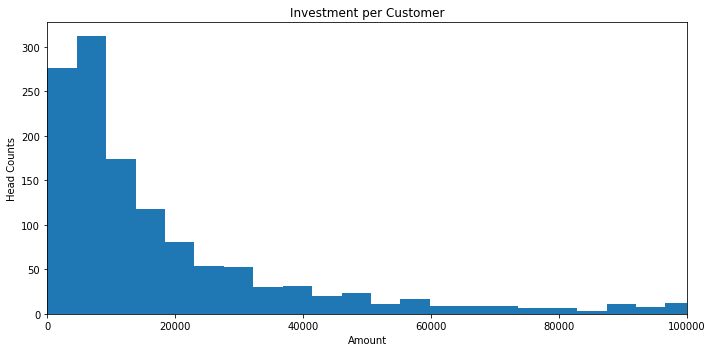

In [32]:
plt.figure(figsize=(10,5))
plt.hist(customer_total["金額"], bins=1000)
plt.xlim(0,100000)
plt.title("Investment per Customer")
plt.ylabel("Head Counts")
plt.xlabel("Amount")
plt.tight_layout()
plt.savefig('Investment per Customer small.png', dpi=500)
plt.show()

In [27]:
np.unique(invest["風險等級"], return_counts=True)

(array(['RR1', 'RR2', 'RR3', 'RR4', 'RR5'], dtype=object),
 array([  61,   99,  521, 2609, 2530], dtype=int64))

In [ ]:
vis_vec = []
amount = []
risk_level = []
for c in customer:
    money = customer_total.loc[customer_total["客戶"]==c, "金額"].values[0]
    level = customer_total.loc[customer_total["客戶"]==c, "weight_level"].values[0]
    if money<100000:
        vis_vec.append(X_embedded[id_list.index(c)])
        amount.append(money)
        risk_level.append(level)
vis_vec = np.vstack(vis_vec)

In [ ]:
plt.hist(risk_level,bins=40)
plt.title("weighted risk level")
plt.show()

In [ ]:
amount = (np.array(amount)-min(amount))/(max(amount)-min(amount))

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots(figsize=(16,9))
points = ax.scatter(vis_vec[:,0], vis_vec[:,1], c=risk_level, s=50, cmap=cmap)
f.colorbar(points)
plt.title("risk level")
plt.show()

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots(figsize=(16,9))
points = ax.scatter(vis_vec[:,0], vis_vec[:,1], c=amount, s=50, cmap=cmap)
f.colorbar(points)
plt.title("investment amount")
plt.show()

# 產品名稱

In [ ]:
product_corpus = "".join(list(invest["基金簡稱"]))

In [ ]:
jieba.set_dictionary('C:/Users/thtang/Desktop/dict.txt.big.txt')

In [ ]:
product_words = jieba.lcut(product_corpus)

In [ ]:
" ".join(product_words).replace("基金","").replace("野村","")

In [ ]:
freq = nltk.FreqDist(product_words)

In [ ]:
freq.most_common()